# Univariate LSTM

## Importing Data

In [153]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout, BatchNormalization, Dense
from math import sqrt

In [154]:
df = pd.read_csv("data_imputed.csv")

In [155]:
df['timestamp_local'] = pd.to_datetime(df['timestamp_local'])

In [156]:
df = df.set_index("timestamp_local")

In [157]:
df.head()

,temp,city_name,country_code,aqi,co,no2,o3,pm10,pm25,so2
timestamp_local,,,,,,,,,,
2022-02-01 00:00:00,12.6,Gujrāt,PK,385.0,1339.8,76.0,10.7,491.7,347.67,238.0
2022-02-01 01:00:00,11.5,Gujrāt,PK,404.0,1437.6,76.0,9.3,508.3,359.33,268.0
2022-02-01 02:00:00,11.9,Gujrāt,PK,421.0,1535.5,76.0,8.0,525.0,371.00,298.0
2022-02-01 03:00:00,12.2,Gujrāt,PK,425.0,1659.0,68.3,5.3,529.3,374.00,275.7
2022-02-01 04:00:00,11.9,Gujrāt,PK,430.0,1782.5,60.7,2.7,533.7,377.00,253.3


In [158]:
df.describe()

,temp,aqi,co,no2,o3,pm10,pm25,so2
count,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000,18218.000000
mean,24.083621,159.573883,363.736491,25.814211,77.881299,120.487095,82.541621,44.371051
std,8.922981,60.348983,357.179074,21.451682,55.249105,88.959148,65.280359,49.000648
min,3.000000,33.000000,46.700000,0.000000,0.000000,9.000000,6.000000,0.000000
25%,17.000000,112.000000,138.300000,8.000000,30.700000,61.300000,40.000000,16.700000
50%,25.200000,155.000000,254.300000,20.000000,69.000000,92.000000,60.000000,27.700000
75%,30.700000,193.000000,455.550000,39.000000,121.700000,148.000000,101.670000,50.000000
max,46.300000,500.000000,5496.000000,129.000000,313.000000,694.500000,595.560000,390.000000


In [159]:
aqi = df[['aqi']]

In [160]:
aqi.head()

,aqi
timestamp_local,
2022-02-01 00:00:00,385.0
2022-02-01 01:00:00,404.0
2022-02-01 02:00:00,421.0
2022-02-01 03:00:00,425.0
2022-02-01 04:00:00,430.0


<Axes: xlabel='timestamp_local'>

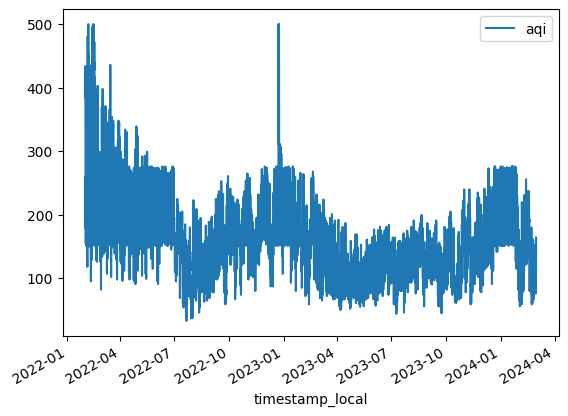

In [161]:
aqi.plot()

<Axes: >

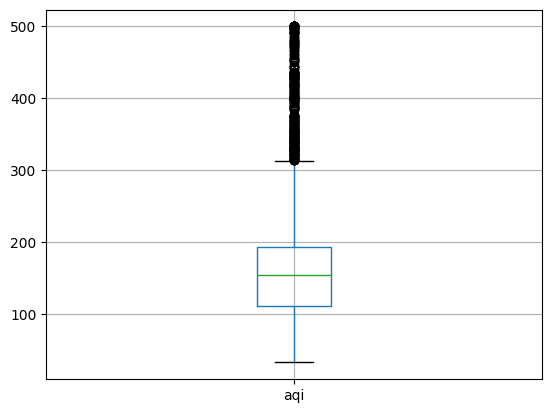

In [162]:
aqi.boxplot()

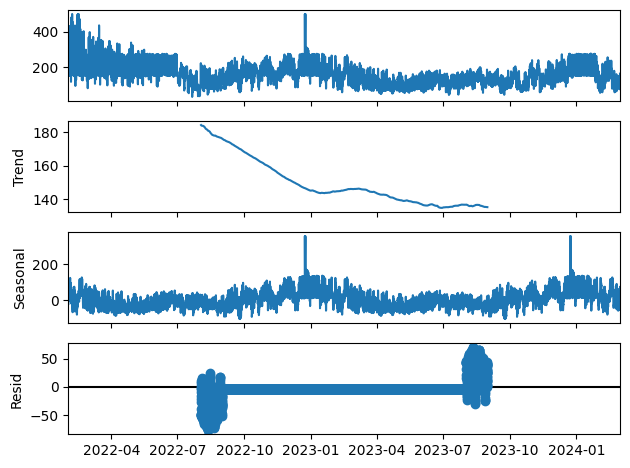

In [163]:
result = seasonal_decompose(aqi, model='additive',period=24*365)
result.plot();

In [164]:
def get_supervised_independent_var(series):
    return series.shift(1).fillna(0).values

aqi['X_shifted_sales'] = get_supervised_independent_var(aqi.aqi)
aqi.head()

C:\Users\Hassan\AppData\Local\Temp\ipykernel_10352\2272257706.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi['X_shifted_sales'] = get_supervised_independent_var(aqi.aqi)


,aqi,X_shifted_sales
timestamp_local,,
2022-02-01 00:00:00,385.0,0.0
2022-02-01 01:00:00,404.0,385.0
2022-02-01 02:00:00,421.0,404.0
2022-02-01 03:00:00,425.0,421.0
2022-02-01 04:00:00,430.0,425.0


In [165]:
def perform_diff(series):
    return pd.Series(series.diff().values)

aqi['diff_aqi'] = perform_diff(aqi['aqi']).values

C:\Users\Hassan\AppData\Local\Temp\ipykernel_10352\4063739168.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi['diff_aqi'] = perform_diff(aqi['aqi']).values


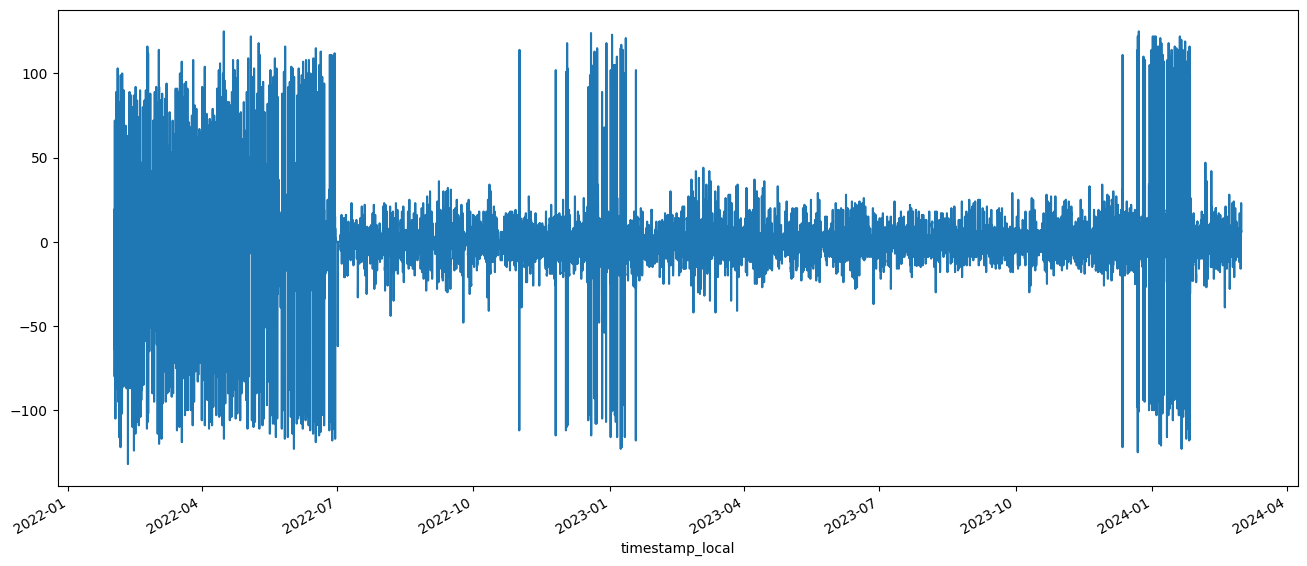

In [166]:
aqi['diff_aqi'].plot(figsize=(16,7));

In [167]:
# invert differenced value
def invert_diff_transform(initial_actual_item, diff_series):
    return np.r_[initial_actual_item, diff_series].cumsum()

aqi['invert_diff_aqi'] = invert_diff_transform(aqi['aqi'].iloc[0], aqi['diff_aqi'].iloc[1:])
aqi.head()

C:\Users\Hassan\AppData\Local\Temp\ipykernel_10352\1589241385.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi['invert_diff_aqi'] = invert_diff_transform(aqi['aqi'].iloc[0], aqi['diff_aqi'].iloc[1:])


,aqi,X_shifted_sales,diff_aqi,invert_diff_aqi
timestamp_local,,,,
2022-02-01 00:00:00,385.0,0.0,NaN,385.0
2022-02-01 01:00:00,404.0,385.0,19.0,404.0
2022-02-01 02:00:00,421.0,404.0,17.0,421.0
2022-02-01 03:00:00,425.0,421.0,4.0,425.0
2022-02-01 04:00:00,430.0,425.0,5.0,430.0


In [168]:
# transform scale
def scale_transform(series):
    series = series.reshape(len(series), 1)
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(series)
    return  scaler, scaler.transform(series)

scaler, aqi['scaled_aqi'] = scale_transform(aqi['aqi'].values)
aqi.head()

C:\Users\Hassan\AppData\Local\Temp\ipykernel_10352\972634112.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scaler, aqi['scaled_aqi'] = scale_transform(aqi['aqi'].values)


,aqi,X_shifted_sales,diff_aqi,invert_diff_aqi,scaled_aqi
timestamp_local,,,,,
2022-02-01 00:00:00,385.0,0.0,NaN,385.0,0.507495
2022-02-01 01:00:00,404.0,385.0,19.0,404.0,0.588865
2022-02-01 02:00:00,421.0,404.0,17.0,421.0,0.661670
2022-02-01 03:00:00,425.0,421.0,4.0,425.0,0.678801
2022-02-01 04:00:00,430.0,425.0,5.0,430.0,0.700214


In [169]:
# Simply use 
aqi['inv_transformed_aqi'] = scaler.inverse_transform(aqi['scaled_aqi'].values.reshape(-1, 1))
aqi.head()

C:\Users\Hassan\AppData\Local\Temp\ipykernel_10352\2352968328.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aqi['inv_transformed_aqi'] = scaler.inverse_transform(aqi['scaled_aqi'].values.reshape(-1, 1))


,aqi,X_shifted_sales,diff_aqi,invert_diff_aqi,scaled_aqi,inv_transformed_aqi
timestamp_local,,,,,,
2022-02-01 00:00:00,385.0,0.0,NaN,385.0,0.507495,385.0
2022-02-01 01:00:00,404.0,385.0,19.0,404.0,0.588865,404.0
2022-02-01 02:00:00,421.0,404.0,17.0,421.0,0.661670,421.0
2022-02-01 03:00:00,425.0,421.0,4.0,425.0,0.678801,425.0
2022-02-01 04:00:00,430.0,425.0,5.0,430.0,0.700214,430.0


In [170]:
# Modelling function for same

# scale train and test data to [-1, 1]
def scale_transform(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)

    return scaler, train_scaled, test_scaled


# invert transform
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [174]:
def fit_lstm(train, batch_size, nb_epoch, neurons_l1):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(Input(batch_shape=(batch_size, X.shape[1], X.shape[2])))
    model.add(LSTM(neurons_l1, 
                   stateful=True))
    # model.add(Dense(32))
    # model.add(Dropout(0.25))
    # model.add(BatchNormalization())
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)

    return model

In [175]:
def forecast(model, batch_size, row):
    x = row.reshape(1, 1, len(row))
    yhat = model.predict(x, batch_size=batch_size)
    return yhat[0,0]

In [ ]:
# Transforming the data to a supervised learning problem.
diff_series = perform_diff(aqi.aqi).dropna()

# Transforming the data to be stationary.
X_series = get_supervised_independent_var(diff_series)
supervised_values = pd.DataFrame([X_series, diff_series.values]).T.values

train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale_transform(train, test)

# Fitting a stateful LSTM network model to the training data.
lstm_model = fit_lstm(train=train_scaled, batch_size=1, nb_epoch=3000, neurons_l1=4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
# Evaluating the static LSTM model on the test data.
lstm_model.predict(train_reshaped, batch_size=1)
# # Report the performance of the forecasts.

# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast: so that statefulness can help LSTM model to learn from previous forecast as well 
    X_row, y_row = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast(lstm_model, 1, X_row)
    # invert scaling
    
    yhat = invert_scale(scaler, X_row, yhat)

    # invert differencing
    yhat = yhat + aqi.aqi.values[-1]
    print(yhat)
    # store forecast
    predictions.append(yhat)
    expected = aqi.aqi[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

18205/18205 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - loss: 0.0441
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0441
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0432
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - loss: 0.0428
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 44s 2ms/step - loss: 0.0427
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - loss: 0.0415
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 114s 6ms/step - loss: 0.0411
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0407
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 30s 2ms/step - loss: 0.0405
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0405
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 1031s 57ms/step - loss: 0.0408
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.0411
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - loss: 0.0414
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0416
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0416
18205/18205 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - loss: 0.0416
18205/18205 ━━━━━━━━

Test RMSE: 62.207


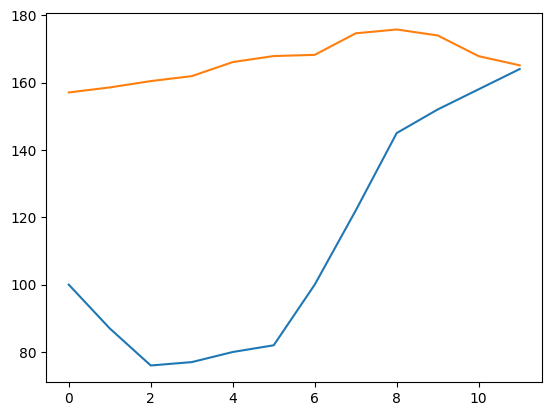

In [178]:
# report performance
rmse = sqrt(mean_squared_error(aqi.aqi.values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(aqi.aqi.values[-12:])
pyplot.plot(predictions)
pyplot.show()